In [1]:
%load_ext autoreload
%autoreload 2
from dataset import show_images, get_multiview_loaders
import torch
import torch.nn as nn
from math import sqrt
from multiview import MultiHeadAttention, MultiView
from train import MultiViewLightningModule
from pytorch_lightning import Trainer
torch.set_float32_matmul_precision('high')  

/lustre/home/lmucko/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/lustre/home/lmucko/.local/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
train_loader, test_loader, class_dict, reverse_dict = get_multiview_loaders(path="animals10", image_size=128)

In [3]:
imgs, labels = next(iter(train_loader))

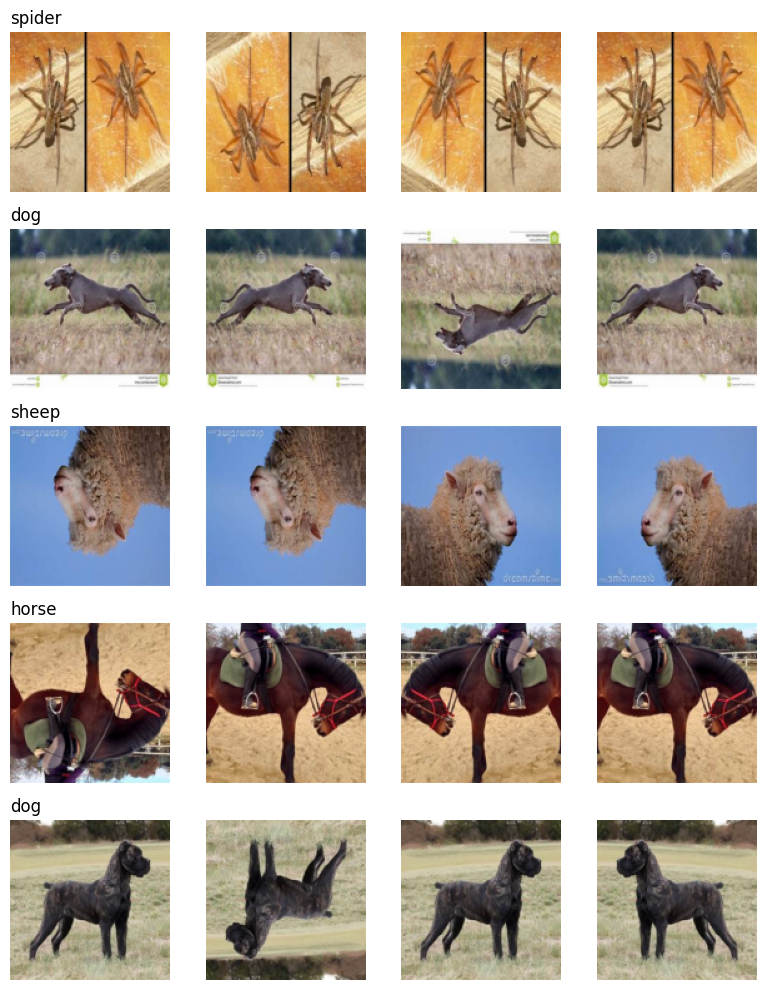

In [4]:
show_images(imgs[:5], labels[:5].tolist(), reverse_dict)

In [7]:
num_classes = 10
model = MultiView(in_channels=3, out_channels=128, num_views=4, d=256, num_classes=num_classes)
lightning_model = MultiViewLightningModule(model=model, num_classes=num_classes, learning_rate=1e-3)
trainer = Trainer(
    max_epochs=10,
    accelerator="gpu",
    devices=1,
    gradient_clip_val=1,
    gradient_clip_algorithm="norm"
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [8]:
trainer.fit(lightning_model, train_dataloaders=train_loader, val_dataloaders=test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params
------------------------------------------------
0 | model    | MultiView          | 2.3 M 
1 | accuracy | MulticlassAccuracy | 0     
------------------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.312     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=10` reached.


In [11]:
lightning_model.eval()
1

1

In [100]:
test_batch = next(iter(test_loader))
x, y = test_batch

In [101]:
y.shape

torch.Size([32])

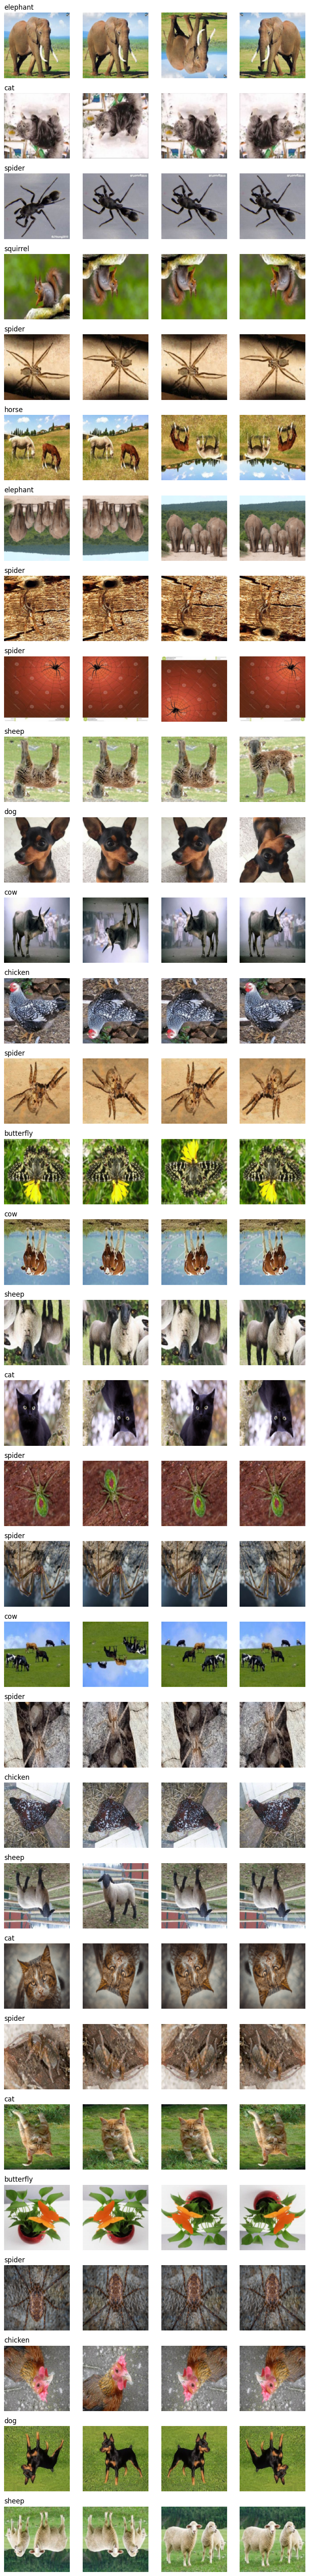

In [102]:
show_images(x, y.tolist(), reverse_dict)

In [103]:
lightning_model.to("cuda")
with torch.no_grad():
    original_logits = lightning_model(x.to("cuda"))

In [104]:
original_logits, original_preds = torch.max(original_logits, dim=1)

In [106]:
[(reverse_dict[i], reverse_dict[j]) for i,j in zip(args.tolist(), y.tolist())]

[('elephant', 'elephant'),
 ('dog', 'cat'),
 ('spider', 'spider'),
 ('spider', 'squirrel'),
 ('spider', 'spider'),
 ('cow', 'horse'),
 ('elephant', 'elephant'),
 ('spider', 'spider'),
 ('dog', 'spider'),
 ('spider', 'sheep'),
 ('dog', 'dog'),
 ('elephant', 'cow'),
 ('chicken', 'chicken'),
 ('spider', 'spider'),
 ('butterfly', 'butterfly'),
 ('horse', 'cow'),
 ('elephant', 'sheep'),
 ('dog', 'cat'),
 ('spider', 'spider'),
 ('spider', 'spider'),
 ('cow', 'cow'),
 ('spider', 'spider'),
 ('chicken', 'chicken'),
 ('horse', 'sheep'),
 ('spider', 'cat'),
 ('spider', 'spider'),
 ('dog', 'cat'),
 ('butterfly', 'butterfly'),
 ('spider', 'spider'),
 ('chicken', 'chicken'),
 ('dog', 'dog'),
 ('sheep', 'sheep')]

In [114]:
import numpy as np 
num_views = 4

for i in range(num_views):
    permuted_x = x.clone()
    permuted_x[0] = x[0][torch.randperm(num_views)]
    with torch.no_grad():
        permuted_logits = lightning_model(permuted_x.to("cuda"))

    permuted_classes = torch.argmax(permuted_logits, dim=1)
    print(original_preds.size(0) - (permuted_classes == original_preds).sum())

tensor(1, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(1, device='cuda:0')
